In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from bibliotheque import *
from signal_tools import *
import tqdm

%matplotlib inline

## PATH

In [3]:
root = '/crnldata/'

In [4]:
data_file = root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_staged.nc'

## PARAMS

In [5]:
eeg_chans = ['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1']
respi_chan = 'DEBIT'
ecg_chan = 'ECG'
eog_chans = ['EOGDt-A2','EOGG-A1']
sel_chans = ['Fp2-C4','C4-T4','T4-O2','Fz-Cz','Cz-Pz','Fp1-C3','C3-T3','T3-O1','DEBIT','ECG']
stages = ['W','R','N1','N2','N3']

In [6]:
step = 40 # n_wavelets
start_freq = 10 # start wavelet freq
stop_freq = 20 # stop wavelet freq

In [7]:
srate = 256

amp = 1
time_cmw = np.arange(-2,2,1/srate)
range_freqs = np.linspace(start_freq,stop_freq,step)
n_cycles = np.linspace(5,10,step) # 5 to 10 cycles from 10 to 20 Hz freqs , equally spaced
m = 0

cmw_family_params = {'amp':amp, 'time':time_cmw, 'n_cycles':n_cycles, 'm':m, 'range':range_freqs}

save = False

TOOLS

GO

In [8]:
if save:
    da = xr.load_dataarray(data_file)
    da = da.sel(stage = 'N2').dropna(dim='time')
    chans = list(da.coords['chan'].values)
    
    concat = []
    
    loop = range(len(eeg_chans))
    loop = tqdm.tqdm(loop, desc='chan')
    
    for i in loop:
        chan = eeg_chans[i]
        sig = da.loc[chan, :].dropna(dim='time').values
        time_sig = time_vector(sig=sig, srate=srate)
        da_features = extract_features_from_cmw_family(sig, time_sig, cmw_family_params, module_method='abs')
        concat.append(da_features)
    da_all_features = xr.concat(concat, dim = 'chan')
    da_all_features = da_all_features.assign_coords({'chan':eeg_chans})
    
    da_all_features.to_netcdf(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_features_all.nc')
else:
    da_all_features = xr.load_dataarray(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_features_all.nc')

In [9]:
da_all_features

<xarray.DataArray 'features' (chan: 8, freqs: 40, time: 2265600)>
array([[[1.74040837e+03, 1.76557262e+03, 1.78582907e+03, ...,
         3.64049099e+04, 3.64578224e+04, 3.63525372e+04],
        [1.71473703e+03, 1.74224873e+03, 1.76484569e+03, ...,
         3.63350314e+04, 3.62726766e+04, 3.60616699e+04],
        [1.67058402e+03, 1.69841892e+03, 1.72129267e+03, ...,
         3.60717122e+04, 3.59175075e+04, 3.56227859e+04],
        ...,
        [4.11414445e+02, 4.08861914e+02, 4.04629397e+02, ...,
         5.72489831e+03, 5.83819644e+03, 5.92422602e+03],
        [4.61414570e+02, 4.62890290e+02, 4.62721145e+02, ...,
         5.86873983e+03, 5.96394237e+03, 6.03198334e+03],
        [5.13810774e+02, 5.19642799e+02, 5.23890295e+02, ...,
         6.01198921e+03, 6.08954064e+03, 6.14006115e+03]],

       [[5.34401511e+04, 5.33011342e+04, 5.28890354e+04, ...,
         6.04175454e+04, 6.19493529e+04, 6.31528566e+04],
        [4.94292529e+04, 4.92036385e+04, 4.87196620e+04, ...,
         5.68209003e+04, 5.82785350e+04, 5.94269263e+04],
        [4.58688760e+04, 4.55735301e+04, 4.50333260e+04, ...,
         5.38281277e+04, 5.51973922e+04, 5.62751598e+04],
...
        [1.82686230e+05, 1.82456168e+05, 1.81333010e+05, ...,
         5.78903711e+04, 5.86094262e+04, 5.90602573e+04],
        [1.77316610e+05, 1.77070644e+05, 1.75956848e+05, ...,
         5.65160789e+04, 5.72321246e+04, 5.76841046e+04],
        [1.72223331e+05, 1.71964432e+05, 1.70861816e+05, ...,
         5.51356170e+04, 5.58509517e+04, 5.63064693e+04]],

       [[1.90522229e+05, 1.88565227e+05, 1.85615076e+05, ...,
         1.93511165e+04, 1.85633535e+04, 1.78089529e+04],
        [1.84946415e+05, 1.83575117e+05, 1.81281888e+05, ...,
         2.04511711e+04, 1.95048427e+04, 1.85976617e+04],
        [1.79951288e+05, 1.79100091e+05, 1.77388830e+05, ...,
         2.09099583e+04, 1.98642247e+04, 1.88612855e+04],
        ...,
        [5.51400638e+04, 5.49740683e+04, 5.45334022e+04, ...,
         8.57636197e+02, 8.95379867e+02, 9.28502938e+02],
        [5.33972461e+04, 5.32053723e+04, 5.27453876e+04, ...,
         7.69426823e+02, 8.12829483e+02, 8.51513073e+02],
        [5.17965133e+04, 5.15860581e+04, 5.11139719e+04, ...,
         7.09221034e+02, 7.55887399e+02, 7.97845378e+02]]])
Coordinates:
    feature  <U5 'power'
  * freqs    (freqs) float64 10.0 10.26 10.51 10.77 ... 19.23 19.49 19.74 20.0
  * time     (time) float64 0.0 0.003906 0.007812 ... 8.85e+03 8.85e+03 8.85e+03
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'

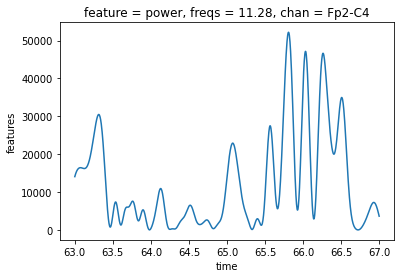

In [10]:
da_all_features.loc['Fp2-C4',range_freqs[5],63:67].plot()

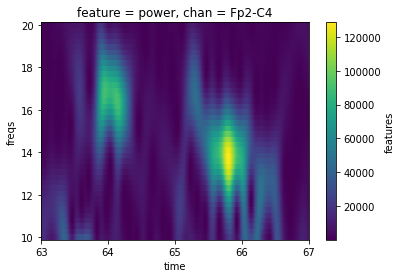

In [11]:
da_all_features.loc['Fp2-C4',:,63:67].plot()

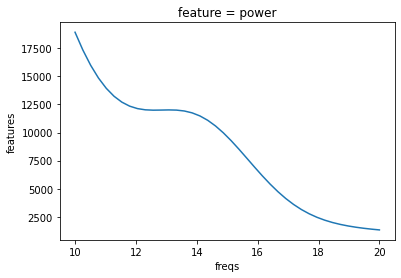

In [12]:
da_all_features.loc[:,:,:].mean(['time','chan']).plot()

In [13]:
if save:
    resp_features = pd.read_excel(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/df_analyse/resp_features.xlsx')
    da_tf_stretched = None
    loop = range(len(eeg_chans))
    loop = tqdm.tqdm(loop, desc='chan')
    for i in loop:
        chan = eeg_chans[i]
        for fi in range_freqs:
            sig = da_all_features.loc[chan, fi, :].values
            sig_stretched = stretch_data(resp_features=resp_features, nb_point_by_cycle=1000, data=sig, srate=srate)
            if da_tf_stretched is None:
                da_tf_stretched = init_da({'chan':eeg_chans, 'cycle':np.arange(0,sig_stretched.shape[0],1), 'freq':range_freqs, 'point':np.arange(0,sig_stretched.shape[1],1)})
            da_tf_stretched.loc[chan, : , fi, :] = sig_stretched      
    da_tf_stretched.to_netcdf(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_tf_stretched.nc')
else:
    da_tf_stretched = xr.load_dataarray(root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/dataarray/da_tf_stretched.nc')
del da_all_features

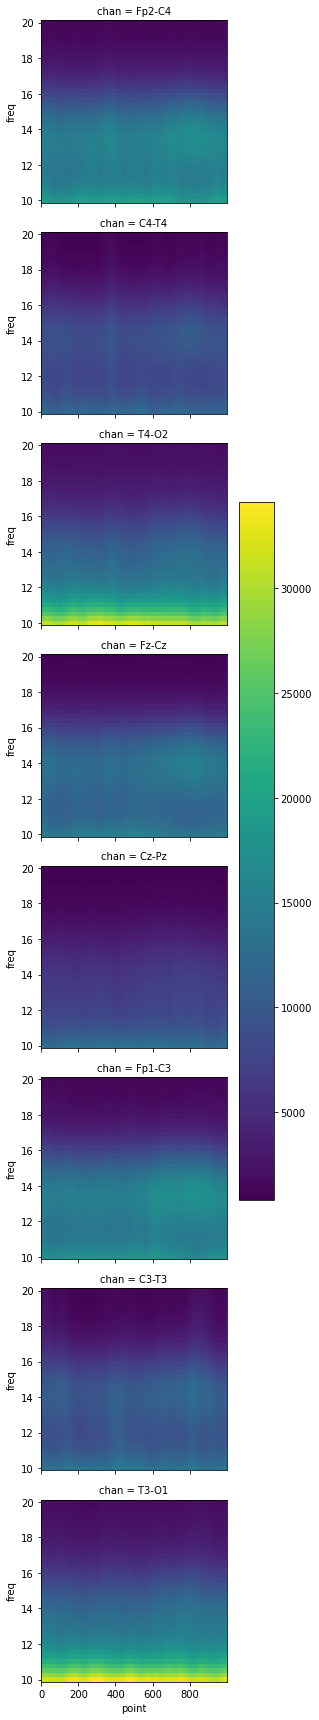

In [14]:
da_tf_stretched.loc[:,:,:,:].mean('cycle').plot.pcolormesh(x='point', row = 'chan')

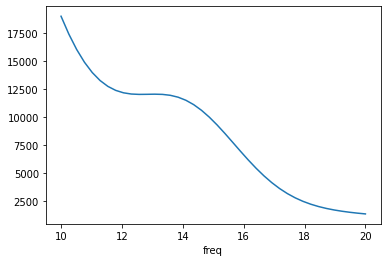

In [15]:
da_tf_stretched.loc[:,:,:,:].mean(['cycle','chan','point']).plot()

In [16]:
da_tf_stretched.coords

Coordinates:
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'
  * cycle    (cycle) int64 0 1 2 3 4 5 6 ... 3063 3064 3065 3066 3067 3068 3069
  * freq     (freq) float64 10.0 10.26 10.51 10.77 ... 19.23 19.49 19.74 20.0
  * point    (point) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

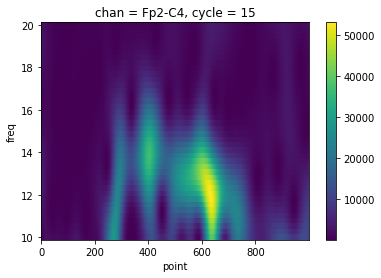

In [17]:
da_tf_stretched.loc['Fp2-C4',15,:,:].plot()

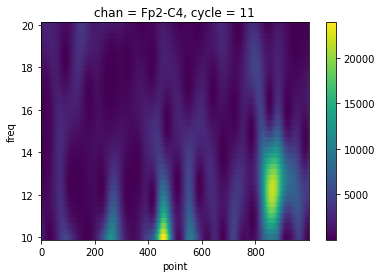

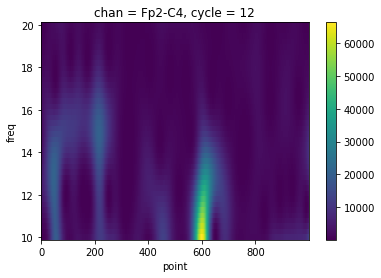

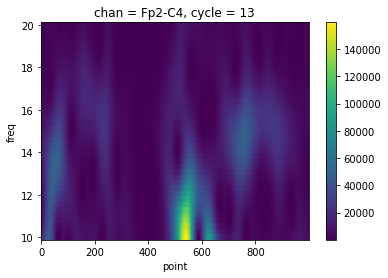

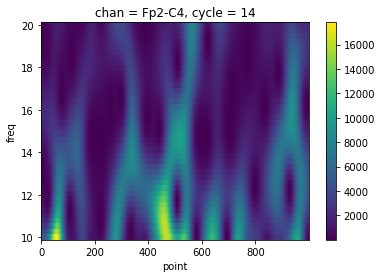

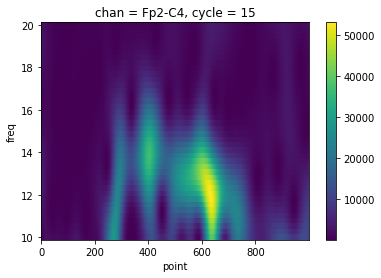

In [18]:
for i in range(10,15):
    da_tf_stretched.loc['Fp2-C4',i+1,:,:].plot.pcolormesh(x='point')
    plt.show()

In [19]:
freqs = da_tf_stretched.coords['freq'].values

In [20]:
cycles_spindled = np.load('../df_analyse/cycle_spindled.npy')

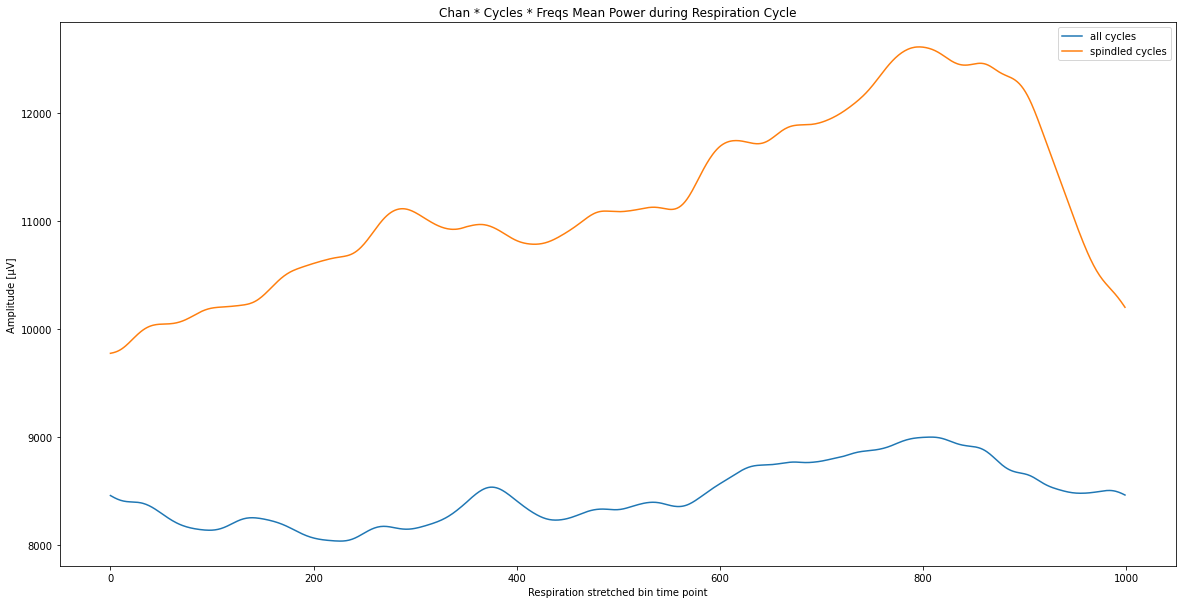

In [21]:
fig, ax = plt.subplots(figsize = (20,10)) # to save
da_tf_stretched.mean(['chan','cycle','freq']).plot(ax=ax)
da_tf_stretched.sel(cycle = cycles_spindled).mean(['chan','freq','cycle']).plot(ax=ax)
ax.legend(['all cycles' , 'spindled cycles'])
ax.set_ylabel('Amplitude [µV]')
ax.set_xlabel('Respiration stretched bin time point')
ax.set_title('Chan * Cycles * Freqs Mean Power during Respiration Cycle')
if save:
    plt.savefig('../presentation/mean_chan_cycle_freq_power_lineplot')
plt.show()

In [22]:
eeg_chans

['Fp2-C4', 'C4-T4', 'T4-O2', 'Fz-Cz', 'Cz-Pz', 'Fp1-C3', 'C3-T3', 'T3-O1']

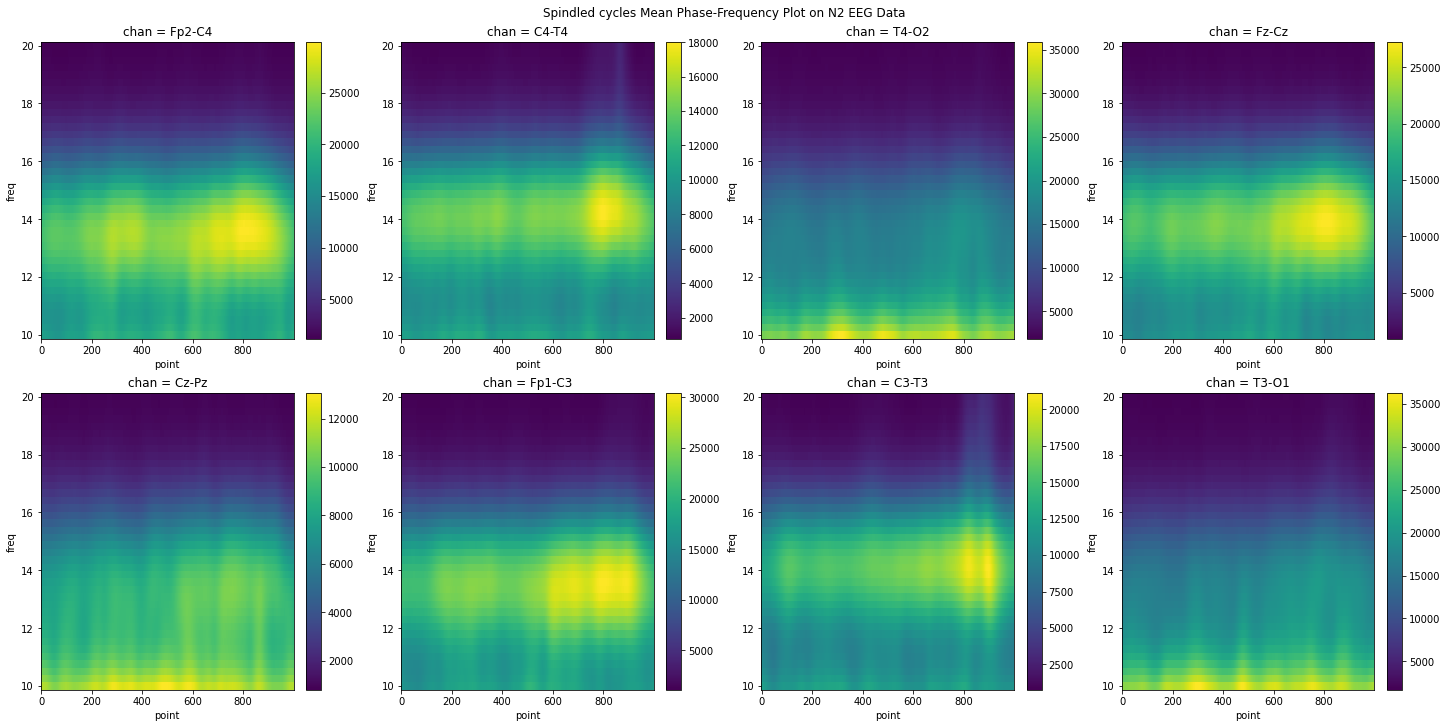

In [23]:
# to save
chans_1 = eeg_chans[:4]
chans_2 = eeg_chans[4:]
chans_merge = [ chans_1 , chans_2 ]
fig, axs = plt.subplots(nrows = 2, ncols = len(chans_1), figsize = (20,10), constrained_layout = True) # to save
fig.suptitle('Spindled cycles Mean Phase-Frequency Plot on N2 EEG Data')
for row , chan_i in enumerate(chans_merge):
    for col, chan in enumerate(chan_i):
        ax = axs[row, col]
        da_tf_stretched.loc[chan,cycles_spindled, :,:].mean('cycle').plot.pcolormesh(x='point', y='freq', ax=ax)
if save:
    plt.savefig('../presentation/phase_freq_2D_plot')
plt.show()

In [28]:
save = False

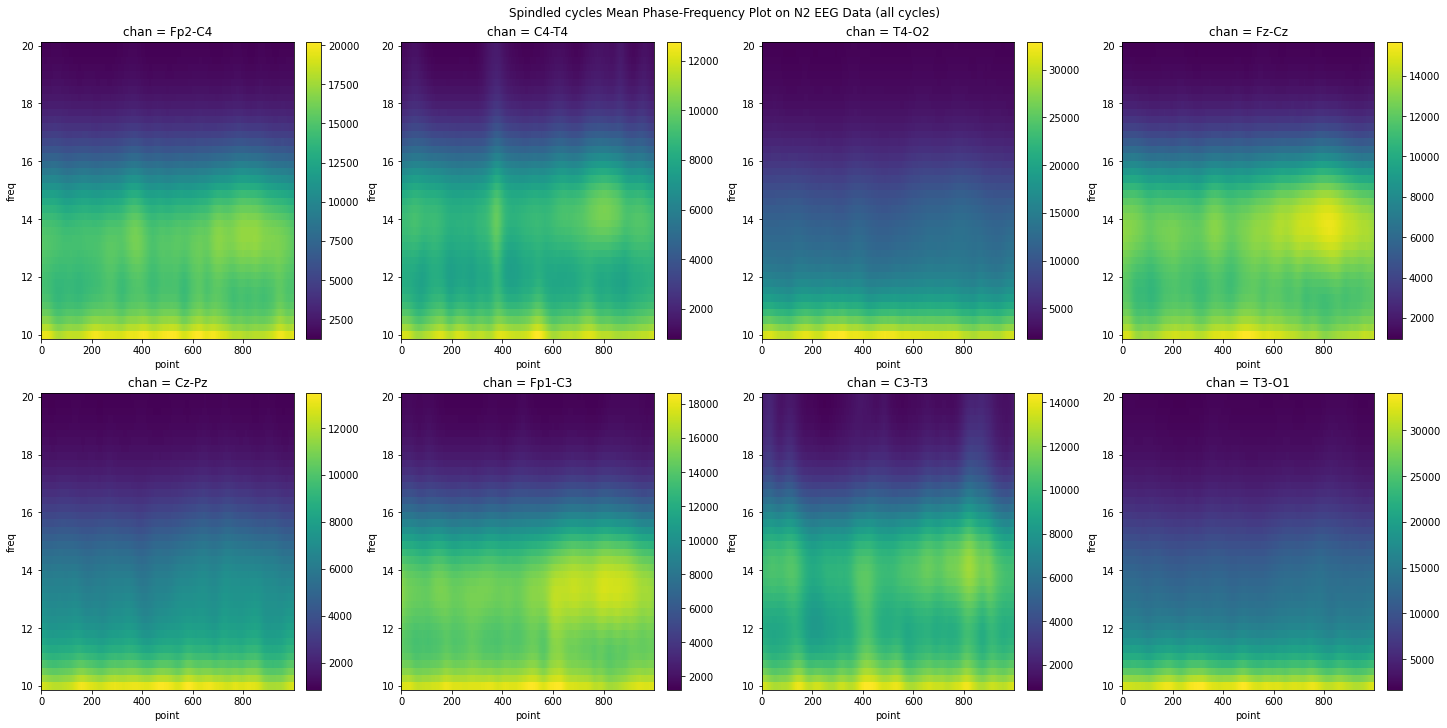

In [29]:
# to save
chans_1 = eeg_chans[:4]
chans_2 = eeg_chans[4:]
chans_merge = [ chans_1 , chans_2 ]
fig, axs = plt.subplots(nrows = 2, ncols = len(chans_1), figsize = (20,10), constrained_layout = True) # to save
fig.suptitle('Spindled cycles Mean Phase-Frequency Plot on N2 EEG Data (all cycles)')
for row , chan_i in enumerate(chans_merge):
    for col, chan in enumerate(chan_i):
        ax = axs[row, col]
        da_tf_stretched.loc[chan,:, :,:].mean('cycle').plot.pcolormesh(x='point', y='freq', ax=ax)
if save:
    plt.savefig('../presentation/phase_freq_2D_plot_all_cycles')
plt.show()